# Seniment Analysis

In [ ]:
!pip install gensim==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Callable, Dict

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

from collections import OrderedDict
import gensim
import gensim.downloader as gloader

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,multilabel_confusion_matrix
from keras.utils.vis_utils import plot_model
from IPython.display import Image as IPythonImage
from IPython.display import display

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download dataset from kaggle
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle 

!cp kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d saurabhshahane/twitter-sentiment-dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
  0% 0.00/7.60M [00:00<?, ?B/s]
100% 7.60M/7.60M [00:00<00:00, 110MB/s]


In [ ]:
!unzip -qq twitter-sentiment-dataset.zip

In [ ]:
data = pd.read_csv('Twitter_Data.csv')
data.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
print("Data shape before deleting the NAN value: ",data.shape)
data = data.dropna(axis=0,how='any')
print("Data shape after deleting the NAN value: ",data.shape)

Data shape before deleting the NAN value:  (162980, 2)
Data shape after deleting the NAN value:  (162969, 2)


In [ ]:
# 1 - positive
# 0 - neutral
# -1 - negative
label = data['category']
data.drop(['category'],axis=1)
label.value_counts()

 1.0    72249
 0.0    55211
-1.0    35509
Name: category, dtype: int64

In [ ]:
# transform the label
encoder = LabelEncoder()
encoder.fit(label)
label = encoder.transform(label)
label = to_categorical(label)
print("Some label after transform: ",label[:2])

Some label after transform:  [[1. 0. 0.]
 [0. 1. 0.]]


Text preprocessing

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.:`\-\'\"]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-zA-Z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub('', text)

def filter_out_uncommon_symbols(text: str) -> str:
    return GOOD_SYMBOLS_RE.sub('', text)

def strip_text(text: str) -> str:
    return text.strip()

def split_text(text: str) -> str:
    return text.split()

def removeLinks(text):
    text = re.sub(r'http\S+','', text, flags=re.MULTILINE)
    return text

def lower(text: str) -> str:
    return text.lower()

PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          removeLinks,
                          remove_stopwords,
                          strip_text,
                          split_text
                          ]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_prepare(text: str,filter_methods=PREPROCESSING_PIPELINE):
    return reduce(lambda x, f: f(x), filter_methods, text)

print('Pre-processing text...')
print('Before:\n{}'.format(data.clean_text[:3]))

# Replace each sentence with its pre-processed version
data.clean_text = data.clean_text.apply(lambda x: text_prepare(x))

print('After:\n{}'.format(data.clean_text[:3]))
print("Pre-processing completed!")

Pre-processing text...
Before:
0    when modi promised “minimum government maximum...
1    talk all the nonsense and continue all the dra...
2    what did just say vote for modi  welcome bjp t...
Name: clean_text, dtype: object
After:
0    [modi, promised, minimum, government, maximum,...
1        [talk, nonsense, continue, drama, vote, modi]
2    [say, vote, modi, welcome, bjp, told, rahul, m...
Name: clean_text, dtype: object
Pre-processing completed!


split dataset

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=16297, random_state=42 ,stratify=label)
train_data, val_data, train_label, val_label = train_test_split(train_data,train_label, test_size=16297, random_state=42 ,stratify=train_label)

train_text = train_data.clean_text
test_text = test_data.clean_text
val_text = val_data.clean_text

print('Train data data: ', train_text.shape)
print('Train label: ', train_label.shape)
print('Test data data: ', test_text.shape)
print('Test label: ', test_label.shape)
print('Val data data: ', val_text.shape)
print('Val label: ', val_label.shape)

Train data data:  (130375,)
Train label:  (130375, 3)
Test data data:  (16297,)
Test label:  (16297, 3)
Val data data:  (16297,)
Val label:  (16297, 3)


In [ ]:
# create the vocabulary 
def build_vocabulary(df):

    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0
    
    for sentence in tqdm(df.values):
        tokens = sentence
        for token in tokens:
          if token not in word_to_idx:
              word_to_idx[token] = curr_idx
              idx_to_word[curr_idx] = token
              curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

# check oov terms 
def check_OOV_terms(embedding_model,word_listing):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
corpus = pd.concat([train_text,val_text],ignore_index=True)
idx_to_word, word_to_idx, word_listing = build_vocabulary(corpus)

print('Index -> Word vocabulary size: {}'.format(len(idx_to_word)))
print('Word -> Index vocabulary size: {}'.format(len(word_to_idx)))
print('The corpus length: {}'.format(len(word_listing)))
print('Some words: {}'.format([(idx_to_word[idx], idx) for idx in np.arange(10) + 1]))

100%|██████████| 146672/146672 [00:01<00:00, 107590.49it/s]

Index -> Word vocabulary size: 113044
Word -> Index vocabulary size: 113044
The corpus length: 113044
Some words: [('pressing', 1), ('issue', 2), ('time', 3), ('crores', 4), ('young', 5), ('people', 6), ('jobs', 7), ('hope', 8), ('current', 9), ('govtmodi', 10)]


In [ ]:
#download the glove
embedding_dimension = 300
download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

try:
    embedding_model = gloader.load(download_path)
except ValueError as e:
    print("Invalid embedding model name! Check the embedding dimension:")
    print("Glove: 50, 100, 200, 300")
    raise e


[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms), float(len(oov_terms)) / len(word_listing)*100))

Total OOV terms: 74124 (65.57%)


In [ ]:
oov_token = "<OOV>"
tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(corpus)

vocabLength = len(tokenizer.word_index)+1 
print("Tokenizer vocabulary length: {}".format(vocabLength))

Tokenizer vocabulary length: 113046


In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int]):

    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension))
    for word, i in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[i] = embedding_vector

    return embedding_matrix


embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)

print("Embedding matrix shape: {}".format(embedding_matrix.shape))

100%|██████████| 113045/113045 [00:00<00:00, 134740.24it/s]

Embedding matrix shape: (113046, 300)


In [ ]:
def convert_text(texts, tokenizer,max_seq_length):

    text_ids = tokenizer.texts_to_sequences(texts)
    text_ids = pad_sequences(text_ids, padding='post', truncating='post', maxlen=max_seq_length,dtype='float32')
    return text_ids

# the length should be same as that in sarcasm
max_seq_length = 300
print("Max sentence length is: {} words".format(max_seq_length))

# Train
train_text = convert_text(train_text, tokenizer,max_seq_length)
print(train_text[:1])
print('Train text shape: ', train_text.shape)

# Val
val_text = convert_text(val_text, tokenizer,max_seq_length)
print('Val text shape: ', val_text.shape)

# Test
test_text = convert_text(test_text, tokenizer,max_seq_length)
print('Test text shape: ', test_text.shape)

Max sentence length is: 300 words
[[4.3500e+02 7.2950e+03 2.9000e+02 1.7000e+01 3.9300e+02 5.6100e+02
  5.0000e+00 1.2100e+02 1.9100e+02 7.0900e+02 1.2103e+04 3.6900e+02
  5.2290e+03 8.1000e+01 4.0530e+03 3.6500e+02 3.0000e+00 1.0000e+01
  1.4400e+02 4.8000e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00 0

In [ ]:
def sentiment_model(compile_info):

    #input layer
    text_input=Input(shape=(max_seq_length,))
    input_embedding = Embedding(input_dim = vocabLength,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix],
                                input_length=max_seq_length,
                                name = "embedding_layer")(text_input)
    conv1 = Conv1D(50, 4, activation = 'relu')(input_embedding)
    maxpooling1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(100, 3, activation = 'relu')(maxpooling1)
    maxpooling2 = MaxPooling1D(2)(conv2)
    dropout1 = Dropout(0.2)(maxpooling2)
    flat = Flatten()(dropout1)
    dense1 = Dense(100, activation = 'relu',name = "dense_sen")(flat)
    dropout2 = Dropout(0.2)(dense1)
    last_output = Dense(3, activation = 'softmax')(dropout2)

    model = Model(inputs=[text_input], outputs=last_output)  
    model.summary()
    model.compile(**compile_info)

    return model

sentimentModel = sentiment_model(compile_info)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 300, 300)         33913800  
                                                                 
 conv1d (Conv1D)             (None, 297, 50)           60050     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 148, 50)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 100)          15100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 73, 100)          0         
 1D)                                                         

In [ ]:
compile_info = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-5),
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
}

#ModelCheckpoint callback：
filepath = '/content/drive/My Drive/nlp-project/SentimentCheckpoint/ep:{epoch:03d}-val_loss:{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, verbose=1, mode='min', peroid=10)

training_info = {
    'verbose': 1,
    'epochs': 40,
    'batch_size': 64,
    'callbacks':[checkpoint]
}




In [ ]:
sentimentHistory = sentimentModel.fit(x=train_text, y=train_label,
                        validation_data=(val_text, val_label),
                        **training_info)

Epoch 1/40
2038/2038 [==============================] - ETA: 0s - loss: 0.9823 - accuracy: 0.5277
Epoch 1: val_loss improved from inf to 0.95414, saving model to /content/drive/My Drive/nlp-project/SentimentCheckpoint/ep:001-val_loss:0.9541.h5
2038/2038 [==============================] - 65s 28ms/step - loss: 0.9823 - accuracy: 0.5277 - val_loss: 0.9541 - val_accuracy: 0.5429
Epoch 2/40
2037/2038 [============================>.] - ETA: 0s - loss: 0.9242 - accuracy: 0.5635
Epoch 2: val_loss improved from 0.95414 to 0.89837, saving model to /content/drive/My Drive/nlp-project/SentimentCheckpoint/ep:002-val_loss:0.8984.h5
2038/2038 [==============================] - 57s 28ms/step - loss: 0.9242 - accuracy: 0.5635 - val_loss: 0.8984 - val_accuracy: 0.5746
Epoch 3/40
2037/2038 [============================>.] - ETA: 0s - loss: 0.8665 - accuracy: 0.6016
Epoch 3: val_loss improved from 0.89837 to 0.84450, saving model to /content/drive/My Drive/nlp-project/SentimentCheckpoint/ep:003-val_loss:

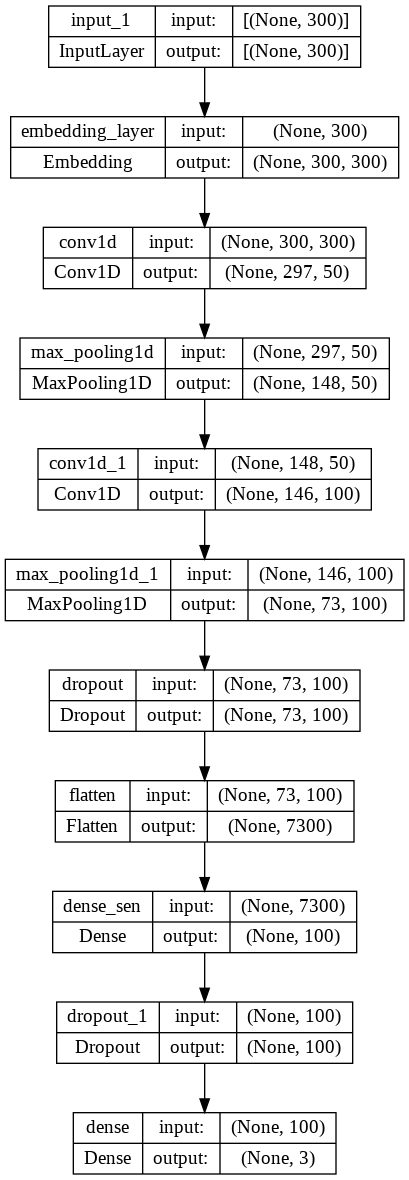

In [ ]:
plot_model(sentimentModel, to_file="model.png", show_shapes=True)
display(IPythonImage('model.png'))

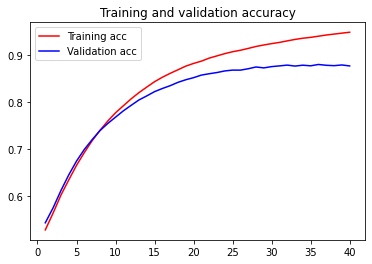

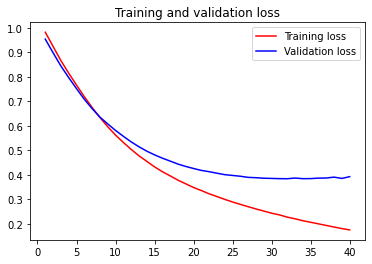

In [ ]:
## Plotting results
def plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot(sentimentHistory)

In [ ]:
results = sentimentModel.evaluate(test_text, test_label, batch_size=64)
results

255/255 [==============================] - 1s 4ms/step - loss: 0.3570 - accuracy: 0.8877


[0.3569760024547577, 0.887709379196167]

In [ ]:
predictions = sentimentModel.predict(test_text)
prediction = np.argmax(predictions, axis = 1)
prediction = encoder.inverse_transform(prediction)
test_label = np.argmax(test_label, axis = 1)
test_label = encoder.inverse_transform(test_label)

510/510 [==============================] - 1s 2ms/step


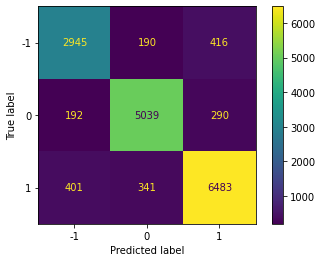

In [ ]:
cf_matrix = confusion_matrix(test_label,prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=[-1,0,1])
disp.plot()
plt.show()

In [ ]:
report = classification_report(test_label, prediction, zero_division=True,labels=[-1,0,1], target_names=["negative","neutral","positive"])
print(report)

              precision    recall  f1-score   support

    negative       0.83      0.83      0.83      3551
     neutral       0.90      0.91      0.91      5521
    positive       0.90      0.90      0.90      7225

    accuracy                           0.89     16297
   macro avg       0.88      0.88      0.88     16297
weighted avg       0.89      0.89      0.89     16297



# Emotion Detection

Download dataset

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle 

!cp kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle (1).json
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 138MB/s]


In [ ]:
!unzip -qq emotions-dataset-for-nlp.zip

In [ ]:
emotion_train = pd.read_csv('train.txt',names=['text','Sentiment'],sep=';',encoding='utf-8')
emotion_test = pd.read_csv('test.txt',names=['text','Sentiment'],sep=';',encoding='utf-8')
emotion_val = pd.read_csv('val.txt',names=['text','Sentiment'],sep=';',encoding='utf-8')
print('Train data shape: ',emotion_train.shape)
print('Test data shape: ',emotion_test.shape)
print('Val data shape: ',emotion_val.shape)

Train data shape:  (16000, 2)
Test data shape:  (2000, 2)
Val data shape:  (2000, 2)


In [ ]:
emotion_train.head()

,text,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
emotionData = pd.concat([emotion_train,emotion_test,emotion_val])
print("Shape of the dataset:",emotionData.shape)

Shape of the dataset: (20000, 2)


In [ ]:
# the distribution of the label
emotionLabel = emotionData['Sentiment']
emotionData.drop(['Sentiment'],axis=1)
uniqueLabel = emotionLabel.unique()
emotionLabel.value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: Sentiment, dtype: int64

In [ ]:
# transform the label
encoderEmotion = LabelEncoder()
encoderEmotion.fit(emotionLabel)
emotionLabel = encoderEmotion.transform(emotionLabel)
emotionLabel = to_categorical(emotionLabel)
print("Some label example: ",emotionLabel[:3])

Some label example:  [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


Text processing

In [ ]:
PREPROCESSING_PIPELINE_EMOTION = [
                          lower,
                          remove_stopwords,
                          strip_text,
                          split_text
                          ]


def text_prepare_e(text: str,filter_methods=PREPROCESSING_PIPELINE_EMOTION):
    return reduce(lambda x, f: f(x), filter_methods, text)

print('Pre-processing text...')
print('Before:\n{}'.format(emotionData.text[:3]))

# Replace each sentence with its pre-processed version
emotionData.text = emotionData.text.apply(lambda x: text_prepare_e(x))

print('After:\n{}'.format(emotionData.text[:3]))
print("Pre-processing completed!")

Pre-processing text...
Before:
0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
Name: text, dtype: object
After:
0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
Name: text, dtype: object
Pre-processing completed!


Split the dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(emotionData, emotionLabel, test_size=2000, random_state=42 ,stratify=emotionLabel)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=2000, random_state=42 ,stratify=y_train)

x_train = x_train.text
x_test = x_test.text
x_val = x_val.text

print('Train data data: ', x_train.shape)
print('Train label: ', y_train.shape)
print('Test data data: ', x_test.shape)
print('Test label: ', y_test.shape)
print('Val data data: ', x_val.shape)
print('Val label: ', y_val.shape)

Train data data:  (16000,)
Train label:  (16000, 6)
Test data data:  (2000,)
Test label:  (2000, 6)
Val data data:  (2000,)
Val label:  (2000, 6)


In [ ]:
# create the vocabulary
corpus_emotion = pd.concat([x_train,x_val],ignore_index=True)
idx_to_word_e, word_to_idx_e, word_listing_e = build_vocabulary(corpus_emotion)

print('Index -> Word vocabulary size: {}'.format(len(idx_to_word_e)))
print('Word -> Index vocabulary size: {}'.format(len(word_to_idx_e)))
print('The corpus length: {}'.format(len(word_listing_e)))
print('Some words: {}'.format([(idx_to_word_e[idx], idx) for idx in np.arange(10) + 1]))

100%|██████████| 18000/18000 [00:00<00:00, 443786.90it/s]

Index -> Word vocabulary size: 16067
Word -> Index vocabulary size: 16067
The corpus length: 16067
Some words: [('life', 1), ('make', 2), ('sense', 3), ('would', 4), ('help', 5), ('lot', 6), ('suffering', 7), ('made', 8), ('see', 9), ('jacque', 10)]


In [ ]:
oov_terms_e = check_OOV_terms(embedding_model, word_listing_e)
print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms_e), float(len(oov_terms_e)) / len(word_listing_e)*100))

Total OOV terms: 1091 (6.79%)


In [ ]:
oov_token = "<OOV>"
tokenizer_e = Tokenizer(oov_token=oov_token)
tokenizer_e.fit_on_texts(corpus_emotion)

vocabLength_e = len(tokenizer_e.word_index)+1 
print("Tokenizer vocabulary length: {}".format(vocabLength_e))

Tokenizer vocabulary length: 16069


In [ ]:
embedding_matrix_e = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer_e.word_index)

print("Embedding matrix shape: {}".format(embedding_matrix_e.shape))

100%|██████████| 16068/16068 [00:00<00:00, 260807.94it/s]

Embedding matrix shape: (16069, 300)


In [ ]:
max_seq_length_e = 300

# Train
x_train = convert_text(x_train, tokenizer_e,max_seq_length_e)

print(x_train[:1])
print('Train text shape: ', x_train.shape)

# Val
x_val = convert_text(x_val, tokenizer_e,max_seq_length_e)
print('Val text shape: ', x_val.shape)

# Test
x_test = convert_text(x_test, tokenizer_e,max_seq_length_e)
print('Test text shape: ', x_test.shape)

[[  2.  19.  21. 202.  12.  51.  65. 648.  47. 202.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   

In [ ]:
def emotion_model(compile_info):

    #input layer
    text_input=Input(shape=(max_seq_length_e,))
    input_embedding = Embedding(input_dim = vocabLength_e,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix_e],
                                input_length=max_seq_length_e,
                                name = "embedding_emotion")(text_input)
    conv1 = Conv1D(50, 4, activation = 'relu')(input_embedding)
    maxpooling1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(100, 3, activation = 'relu')(maxpooling1)
    maxpooling2 = MaxPooling1D(2)(conv2)
    dropout1 = Dropout(0.2)(maxpooling2)
    flat = Flatten()(dropout1)
    dense1 = Dense(100, activation = 'relu',name = "dense_sen")(flat)
    dropout2 = Dropout(0.2)(dense1)
    last_output = Dense(units = 6, activation = "softmax", name="out")(dropout2)

    model = Model(inputs=[text_input], outputs=last_output)  
    model.summary()
    model.compile(**compile_info)

    return model

In [ ]:
filepath_e = '/content/drive/My Drive/nlp-project/EmotionCheckpoint/ep:{epoch:03d}-val_loss:{val_loss:.4f}.h5'
checkpoint_e = ModelCheckpoint(filepath_e, monitor='val_loss', save_best_only=True, verbose=1, mode='min', peroid=10)

training_info_e = {
    'verbose': 1,
    'epochs': 40,
    'batch_size': 64,
    'callbacks':[checkpoint_e]
}
compile_info_e = {
    'optimizer': keras.optimizers.Adam(learning_rate=5e-5),
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy'],
}

In [ ]:
emotionModel = emotion_model(compile_info_e)
emotionHistory = emotionModel.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info_e)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_emotion (Embeddin  (None, 300, 300)         4820700   
 g)                                                              
                                                                 
 conv1d_4 (Conv1D)           (None, 297, 50)           60050     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 148, 50)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 146, 100)          15100     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 73, 100)          0   

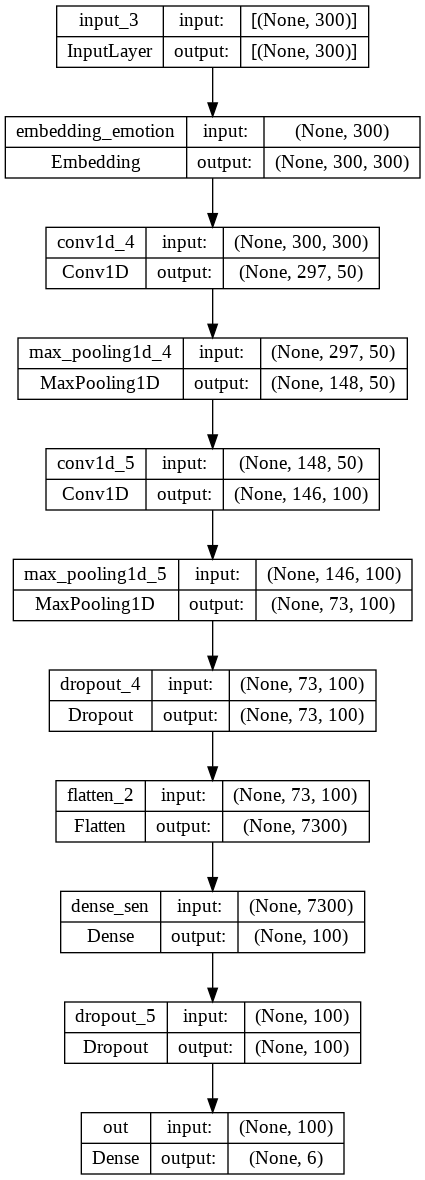

In [ ]:
plot_model(emotionModel, to_file="emotionModel.png", show_shapes=True)
display(IPythonImage('emotionModel.png'))

In [ ]:
results_e = emotionModel.evaluate(x_test, y_test, batch_size=64)
results_e

32/32 [==============================] - 0s 6ms/step - loss: 0.3944 - accuracy: 0.8890


[0.39436423778533936, 0.8889999985694885]

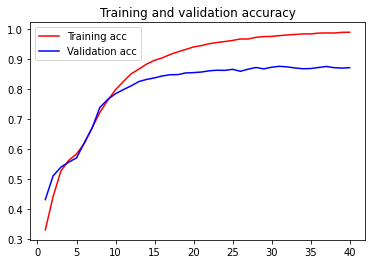

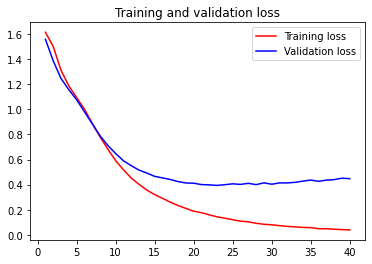

In [ ]:
plot(emotionHistory)

In [ ]:
prediction_e = emotionModel.predict(x_test)
prediction_e = np.argmax(prediction_e, axis = 1)
prediction_e = encoderEmotion.inverse_transform(prediction_e)
y_test = np.argmax(y_test, axis = 1)
y_test = encoderEmotion.inverse_transform(y_test)

63/63 [==============================] - 0s 3ms/step


In [ ]:
cf_matrix_e = multilabel_confusion_matrix(y_test,prediction_e)
disp_e = ConfusionMatrixDisplay(confusion_matrix=cf_matrix_e,display_labels=uniqueLabel)
print(cf_matrix_e)

[[[1698   31]
  [  27  244]]

 [[1735   28]
  [  35  202]]

 [[1264   60]
  [  55  621]]

 [[1792   44]
  [  34  130]]

 [[1383   37]
  [  50  530]]

 [[1906   22]
  [  21   51]]]


In [ ]:
print(classification_report(y_test, prediction_e, zero_division=True,labels=uniqueLabel))

              precision    recall  f1-score   support

     sadness       0.93      0.91      0.92       580
       anger       0.89      0.90      0.89       271
        love       0.75      0.79      0.77       164
    surprise       0.70      0.71      0.70        72
        fear       0.88      0.85      0.87       237
         joy       0.91      0.92      0.92       676

    accuracy                           0.89      2000
   macro avg       0.84      0.85      0.85      2000
weighted avg       0.89      0.89      0.89      2000



# Personality detection

Download dataset

In [ ]:
!wget http://web.archive.org/web/20160519045708/http://mypersonality.org/wiki/lib/exe/fetch.php?media=wiki:essays.zip

--2023-01-10 21:46:57--  http://web.archive.org/web/20160519045708/http://mypersonality.org/wiki/lib/exe/fetch.php?media=wiki:essays.zip
Resolving web.archive.org (web.archive.org)... 207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:80... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: http://web.archive.org/web/20160316113804/http://mypersonality.org/wiki/lib/exe/fetch.php?media=wiki:essays.zip [following]
--2023-01-10 21:47:01--  http://web.archive.org/web/20160316113804/http://mypersonality.org/wiki/lib/exe/fetch.php?media=wiki:essays.zip
Reusing existing connection to web.archive.org:80.
HTTP request sent, awaiting response... 200 OK
Length: 3055499 (2.9M) [application/zip]
Saving to: ‘fetch.php?media=wiki:essays.zip’

fetch.php?media=wik 100%[===================>]   2.91M  1.96MB/s    in 1.5s    

2023-01-10 21:47:03 (1.96 MB/s) - ‘fetch.php?media=wiki:essays.zip’ saved [3055499/3055499]



In [ ]:
!unzip -qq fetch.php?media=wiki:essays.zip

In [ ]:
data_p = pd.read_csv('essays.csv',encoding='cp1252')
data_p.head()

,#AUTHID,TEXT,cEXT,cNEU,cAGR,cCON,cOPN
0,1997_504851.txt,"Well, right now I just woke up from a mid-day ...",n,y,y,n,y
1,1997_605191.txt,"Well, here we go with the stream of consciousn...",n,n,y,n,n
2,1997_687252.txt,An open keyboard and buttons to push. The thin...,n,y,n,y,y
3,1997_568848.txt,I can't believe it! It's really happening! M...,y,n,y,y,n
4,1997_688160.txt,"Well, here I go with the good old stream of co...",y,n,y,n,y


In [ ]:
data_p.shape

(2468, 7)

In [ ]:
# 0: Extroversion
# 1: Neuroticism
# 2: Agreeableness
# 3: Conscientiousness
# 4: Openness
label_p = data_p[['cEXT','cNEU','cAGR','cCON','cOPN']]
encoder_p = LabelEncoder()
encoder_p.fit(['n', 'y'])
label_p.cEXT = encoder_p.transform(label_p.cEXT)
label_p.cNEU = encoder_p.transform(label_p.cNEU)
label_p.cAGR = encoder_p.transform(label_p.cAGR)
label_p.cCON = encoder_p.transform(label_p.cCON)
label_p.cOPN = encoder_p.transform(label_p.cOPN)
label_p[:3]

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,cEXT,cNEU,cAGR,cCON,cOPN
0,0,1,1,0,1
1,0,0,1,0,0
2,0,1,0,1,1


In [ ]:
print(label_p.cEXT.value_counts())
print(label_p.cNEU.value_counts())
print(label_p.cAGR.value_counts())
print(label_p.cCON.value_counts())
print(label_p.cOPN.value_counts())

1    1277
0    1191
Name: cEXT, dtype: int64
0    1235
1    1233
Name: cNEU, dtype: int64
1    1310
0    1158
Name: cAGR, dtype: int64
1    1254
0    1214
Name: cCON, dtype: int64
1    1272
0    1196
Name: cOPN, dtype: int64


Text pre-processing

In [ ]:
PREPROCESSING_PIPELINE_PERSONALITY = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          split_text
                          ]


def text_prepare_p(text: str,filter_methods=PREPROCESSING_PIPELINE_PERSONALITY):
    return reduce(lambda x, f: f(x), filter_methods, text)

print('Pre-processing text...')
print('Before:\n{}'.format(data_p.TEXT[:3]))

# Replace each sentence with its pre-processed version
data_p.TEXT = data_p.TEXT.apply(lambda x: text_prepare_p(x))

print('After:\n{}'.format(data_p.TEXT[:3]))
print("Pre-processing completed!")

Pre-processing text...
Before:
0    Well, right now I just woke up from a mid-day ...
1    Well, here we go with the stream of consciousn...
2    An open keyboard and buttons to push. The thin...
Name: TEXT, dtype: object
After:
0    [well, right, woke, midday, nap, sort, weird, ...
1    [well, go, stream, consciousness, essay, used,...
2    [open, keyboard, buttons, push, thing, finally...
Name: TEXT, dtype: object
Pre-processing completed!


In [ ]:
#split the dataset -- 8:1:1
x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(data_p.TEXT, label_p, test_size=250, random_state=42)
x_train_p, x_val_p, y_train_p, y_val_p = train_test_split(x_train_p,y_train_p, test_size=250, random_state=42)

print('Train data data: ', x_train_p.shape)
print('Train label: ', y_train_p.shape)
print('Test data data: ', x_test_p.shape)
print('Test label: ', y_test_p.shape)
print('Val data data: ', x_val_p.shape)
print('Val label: ', y_val_p.shape)

Train data data:  (1968,)
Train label:  (1968, 5)
Test data data:  (250,)
Test label:  (250, 5)
Val data data:  (250,)
Val label:  (250, 5)


In [ ]:
corpus_p = pd.concat([x_train_p,x_val_p],ignore_index=True)
idx_to_word_p, word_to_idx_p, word_listing_p = build_vocabulary(corpus_p)

print('Index -> Word vocabulary size: {}'.format(len(idx_to_word_p)))
print('Word -> Index vocabulary size: {}'.format(len(word_to_idx_p)))
print('The corpus length: {}'.format(len(word_listing_p)))
print('Some words: {}'.format([(idx_to_word_p[idx], idx) for idx in np.arange(10) + 1]))

oov_terms_p = check_OOV_terms(embedding_model, word_listing_p)
print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_terms_p), float(len(oov_terms_p)) / len(word_listing_p)*100))

100%|██████████| 2218/2218 [00:00<00:00, 22410.47it/s]

Index -> Word vocabulary size: 30273
Word -> Index vocabulary size: 30273
The corpus length: 30273
Some words: [('dont', 1), ('know', 2), ('feel', 3), ('greet', 4), ('never', 5), ('tried', 6), ('communicate', 7), ('strange', 8), ('well', 9), ('stream', 10)]
Total OOV terms: 7716 (25.49%)


In [ ]:
oov_token = "<OOV>"
tokenizer_p = Tokenizer(oov_token=oov_token)
tokenizer_p.fit_on_texts(corpus_p)

vocabLength_p = len(tokenizer_p.word_index)+1 
print("Tokenizer vocabulary length: {}".format(vocabLength_p))

Tokenizer vocabulary length: 30275


In [ ]:
embedding_matrix_p = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer_p.word_index)

print("Embedding matrix shape: {}".format(embedding_matrix_p.shape))

100%|██████████| 30274/30274 [00:00<00:00, 185123.40it/s]

Embedding matrix shape: (30275, 300)


In [ ]:
max_seq_length_p = max(len(x) for x in corpus_p)
print("Max personality sentence length is: {} words".format(max_seq_length_p))

# Train
x_train_p = convert_text(x_train_p, tokenizer_p,max_seq_length_p)

print(x_train_p[:1])
print('Train text shape: ', x_train_p.shape)

# Val
x_val_p = convert_text(x_val_p, tokenizer_p,max_seq_length_p)
print('Val text shape: ', x_val_p.shape)

# Test
x_test_p = convert_text(x_test_p, tokenizer_p,max_seq_length_p)
print('Test text shape: ', x_test_p.shape)

Max personality sentence length is: 1229 words
[[1651.    5.    7. ...    0.    0.    0.]]
Train text shape:  (1968, 1229)
Val text shape:  (250, 1229)
Test text shape:  (250, 1229)


In [ ]:
def personality_model(compile_info):

    #input layer
    text_input=Input(shape=(max_seq_length_p,))
    input_embedding = Embedding(input_dim = vocabLength_p,
                                output_dim = embedding_dimension,
                                weights= [embedding_matrix_p],
                                input_length=max_seq_length_p,
                                name = "embedding_personality")(text_input)
    conv1 = Conv1D(600, 4, activation = 'relu')(input_embedding)
    maxpooling1 = MaxPooling1D(2)(conv1)
    conv2 = Conv1D(300, 3, activation = 'relu')(maxpooling1)
    maxpooling2 = MaxPooling1D(2)(conv2)
    dropout1 = Dropout(0.2)(maxpooling2)
    flat = Flatten()(dropout1)
    dense1 = Dense(100, activation = 'relu')(flat)
    dropout2 = Dropout(0.2)(dense1)
    last_output = Dense(1, activation = "sigmoid", name="out")(dropout2)

    model = Model(inputs=[text_input], outputs=last_output)  
    model.summary()
    model.compile(**compile_info)

    return model

In [ ]:
# train 5 models
for la in y_train_p.columns:
  compile_info_p = {
    'optimizer': keras.optimizers.Adam(learning_rate=1e-4),
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
  }

  training_info_p = {
      'verbose': 1,
      'epochs': 10,
      'batch_size': 64
  }
  filepath_p = '/content/drive/My Drive/nlp-project/PersonalityCheckpoint/%s-ep:{epoch:03d}-val_loss:{val_loss:.4f}.h5'%(la)
  checkpoint_p = ModelCheckpoint(filepath_p, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1, peroid=5)

  personaliyModel = personality_model(compile_info_p)
  personalityHistory = personaliyModel.fit(x=x_train_p, y=y_train_p[la],
                        validation_data=(x_val_p, y_val_p[la]),
                        callbacks=[checkpoint_p],
                        **training_info_p)
  results_p = personaliyModel.evaluate(x_test_p, y_test_p[la], batch_size=64)
  print(results_p)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1229)]            0         
                                                                 
 embedding_personality (Embe  (None, 1229, 300)        9082500   
 dding)                                                          
                                                                 
 conv1d_4 (Conv1D)           (None, 1226, 600)         720600    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 613, 600)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 611, 300)          540300    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 305, 300)         0   